<a href="https://colab.research.google.com/github/ofekih/LightsOutChallenge/blob/main/LightsOutChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ofekih/LightsOutChallenge.git
!rm -rf .git/ LightsOutChallenge/LightsOutChallenge.ipynb build/ src/
!mv LightsOutChallenge/* LightsOutChallenge/.??* .
!mv bin/* /usr/local/lib/
!rmdir LightsOutChallenge/ bin/
!ldconfig

Cloning into 'LightsOutChallenge'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 33), reused 30 (delta 12), pack-reused 0
Unpacking objects: 100% (67/67), done.
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
!make

mkdir -p build
g++ -o build/LightsOutBoard.os src/LightsOutBoardWrapper.cpp -c -I /usr/include/python3.6/ -fPIC
g++ -o LightsOutBoard.so -shared build/LightsOutBoard.os -lboost_python36 -Ofast -funroll-loops


## Modifying C++ Code
If you want to make changes to the C++ python modules (e.g.: to support different board sizes, then do the following):  
Note: You need python3 (any version should be OK) installed.

### Setup
#### For local machine

1. Get boost python by running the next line (should work on any linux/debian machine)  
   Note: This command takes a very long time, only do this once
   ```bash
   make get_boost_python
   ```

2. Take note of your python3 minor version (over here it's python 3.6)  
   Note: Python 3.6.* all have minor version '6' for these purposes
    ```bash
   python3 --version
   ```

#### For Google Colab


1. Restart the runtime (don't run `make` yet) (Note: not factory reset!)

### Making changes

1. Make changes to the C++ files in `src/`

2. Recompile them with the below command:  
    Note: Substitute '8' with your python3 minor version number.  
    Note: Defaults to '6', so can be omitted if running on Google Colab  
    
    ```bash
    make PYTHON_MINOR_VERSION=8
    ```

   Note: On Google Colab, runtime has to be restarted every time before or after any changes in order to unload the python module. You would probably just restart the runtime, make some changes to the C++, and then run the `make` command above (no need to pull GitHub code again).

3. Make a Git commit and push your changes (cannot be done through Colab)

## Code

In [ ]:
from LightsOutBoard import LightsOutBoard8x8, LightsOutBoard4x3, LightsOutBoard1000x1000

In [ ]:
b = LightsOutBoard8x8()
print(b.prettyPrint())
b.setAll(True)
print(b.prettyPrint())
b.flipCoords(2, 5)
print(b.prettyPrint())
print(f'Number of on lights: {b.getNumOn()}')
c = LightsOutBoard8x8()
c.setCoords(2, 6, True)
c.setCoords(0, 0, True)
c.setCoords(5, 6, True)
print(c.prettyPrint())
b.flipBoard(c)
print(b.prettyPrint())
b.flipBoard(c)
print(b.prettyPrint())

 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -

 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O

 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O - O O O O O
 O - - - O O O O
 O O - O O O O O
 O O O O O O O O

Number of on lights: 59
 O - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - - - - - - -
 - - O - - O - -
 - - - - - - - -

 - - O O O O O O
 - O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O - O O O O O
 O - O - O - O O
 O - O - - - - O
 O O - O O - O O

 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O O O O O O O
 O O - O O O O O
 O - - - O O O O
 O O - O O O O O
 O O O O O O O O



Lights Out is an electronic game released by Tiger Electronics in 1995. The game consists of a N by N grid of lights (original game is 5 by 5). When the game starts, a random number or a stored pattern of these lights is switched on. Pressing any of the lights will toggle it and the adjacent lights. The goal of the puzzle is to switch all the lights off, preferably in as few button presses as possible. An example of playing the game: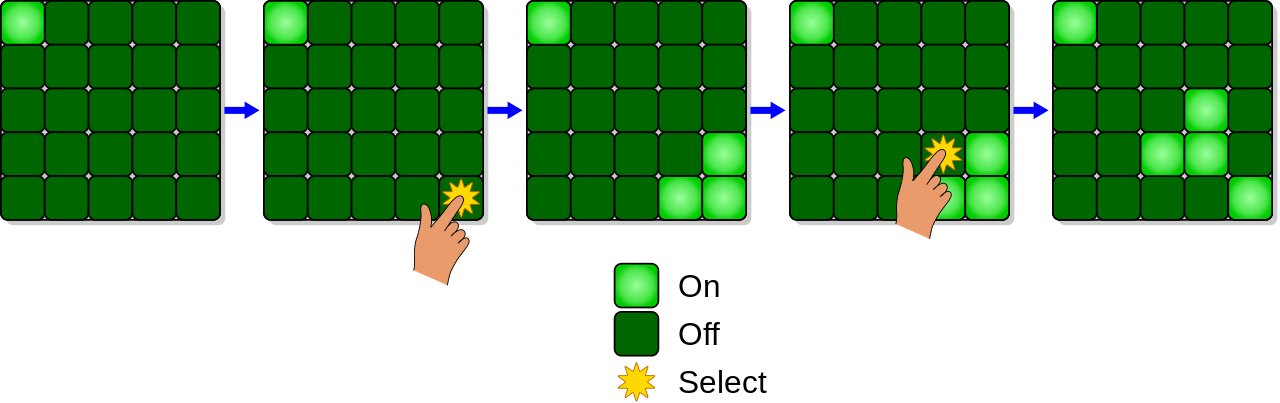

The problem can be mathematically formulated as solving a set of linear equations, as decsribed in paper [1]. To see why this is the case, let's try using tensors to express the problem. Each board can be expressed as a binary matrix, where 1 represents light's on and 0 represents light's off. For example, consider the 3 boards in the image above, we can express them as:

$$
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&0&0\\ 0&0&0&0&0 \\ 0&0&0&0&0 \end{pmatrix} \quad
\rightarrow \quad
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&0&0\\ 0&0&0&0&1 \\ 0&0&0&1&1 \end{pmatrix} \quad
\rightarrow \quad
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&1&0\\ 0&0&1&1&0 \\ 0&0&0&0&1 \end{pmatrix}
$$

To make linear transformation convenient, we can **reshape** a $(n+1)\times(n+1)$ board matrix into a vector by connecting its rows:

$$
B =
\begin{pmatrix} 
b_{00} & b_{01} & b_{02} & \dots & b_{0n} \\ 
b_{10} & \ddots & & & \\ 
b_{20} & & \ddots & & \vdots \\ 
\vdots & & & \ddots & \\ 
b_{n0} & & \dots & & b_{nn} 
\end{pmatrix} \quad
\rightarrow \quad
\vec{b} = 
\begin{pmatrix} 
b_{00} & b_{01} & b_{02} & \dots & b_{ij} & \dots & b_{nn} 
\end{pmatrix}^T
$$

Similarly, an action (pressing a light) on the board can be expressed as a matrix (reshaped as a vector) as well. For example, pressing the light on row 2, column 3 (indexes start from 0) on a 5 by 5 board is:

$$
A_{23} = 
\begin{pmatrix} 0&0&0&0&0 \\ 0&0&0&1&0 \\ 0&0&1&1&1\\ 0&0&0&1&0 \\ 0&0&0&0&0 \end{pmatrix} \quad
\rightarrow \quad
\vec{a_{23}} = 
\begin{pmatrix} 
\dots & 1&0&0&0&1&1&1&0&0&0&1& \dots
\end{pmatrix}^T
$$

As described in paper [1], there are two important properties of this game:
1. Pushing a button twice is equivalent to not pushing it at all. Hence, for any given configuration, we need consider only solutions in which each button is pushed no more than once.
2. The state of a button depends only on how often (whether even or odd) it and its neighbors have been pushed. Hence, the order in which the buttons are pushed is immaterial

This implies that the solution of the light board will be a **set** of action action vectors:

$$
S = \{\vec{a_{ij}}: i, j \in \{0,1,2,\dots,n\}\}
$$

We can then use the **configuration matrix** (reshaped as a vector) to express the solution:

$$
\vec{x} = 
\begin{pmatrix} 
x_{00} & x_{01} & \dots & x_{ij} & \dots & x_{nn}
\end{pmatrix}^T \qquad
\begin{equation}
  x_{ij} =
  \begin{cases}
    1 & \text{if $light_{ij}$ needs to be pressed} \\
    0 & \text{if $light_{ij}$ needs not to be pressed}
  \end{cases}
\end{equation}
$$

and the problem becomes solving the linear system:

$$
A\vec{x}=\vec{b}
$$

where A is defined as:

$$
A =
\begin{pmatrix} 
| & | & & | & & | \\ 
\vec{a_{00}} & \vec{a_{01}} & \dots & \vec{a_{ij}} & \dots & \vec{a_{nn}} \\ 
| & | & & | & & | \\ 
\end{pmatrix} \quad
$$

One thing to notice is that any addition involved will be modular-two addtion, since all matrices and vectors involved are binary.

(This part not finished yet) The problem can be generalized to graph...

(This part not finished yet)
Given an open graph $G$, a *focused gFlow* $(g, ≺)$ on $G$ consists of a
function $g$ : $\overline{O} → 2^{\overline{I}}$ and a partial order $≺$ on the vertices $V$ of $G$ such that for all $u ∈ \overline{O}$,

1. $Odd_G (g(u)) ∩ \overline{O} = \{u\}$
2. $∀v ∈ g(u), u ≺ v$

where $2^{\overline{I}}$
is the powerset of $\overline{I}$ and $Odd_G (A) := \{v ∈ V (G) | |N(v) ∩ A| ≡ 1 mod 2\}$ is the *odd neighbourhood* of $A$.


[1] https://people.sc.fsu.edu/~jburkardt/classes/imps_2017/11_28/2690705.pdf